# NFL Elimination Picks

In [1]:
import bisect
import collections
import datetime
import enum
import errno
import heapq
import json
import math
import random
import statistics
import typing

import matplotlib.pyplot as plt
import numpy as np
import parsel
import pandas as pd
import requests

In [2]:
NUM_TEAMS = 32
NUM_WEEKS = 17

# http://www.espn.com/nfl/schedulegrid

# pre-week-6 schedule shuffles
raw_schedule_old = '''
NFL Schedule Grid
TEAM	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17
ARI	@SF	WSH	DET	@CAR	@NYJ	@DAL	SEA	BYE	MIA	BUF	@SEA	@NE	LAR	@NYG	PHI	SF	@LAR
ATL	SEA	@DAL	CHI	@GB	CAR	@MIN	DET	@CAR	DEN	BYE	@NO	LV	NO	@LAC	TB	@KC	@TB
BAL	CLE	@HOU	KC	@WSH	CIN	@PHI	PIT	BYE	@IND	@NE	TEN	@PIT	DAL	@CLE	JAX	NYG	@CIN
BUF	NYJ	@MIA	LAR	@LV	@TEN	KC	@NYJ	NE	SEA	@ARI	BYE	LAC	@SF	PIT	@DEN	@NE	MIA
CAR	LV	@TB	@LAC	ARI	@ATL	CHI	@NO	ATL	@KC	TB	DET	@MIN	BYE	DEN	@GB	@WSH	NO
CHI	@DET	NYG	@ATL	IND	TB	@CAR	@LAR	NO	@TEN	MIN	BYE	@GB	DET	HOU	@MIN	@JAX	GB
CIN	LAC	@CLE	@PHI	JAX	@BAL	@IND	CLE	TEN	BYE	@PIT	@WSH	NYG	@MIA	DAL	PIT	@HOU	BAL
CLE	@BAL	CIN	WSH	@DAL	IND	@PIT	@CIN	LV	BYE	HOU	PHI	@JAX	@TEN	BAL	@NYG	@NYJ	PIT
DAL	@LAR	ATL	@SEA	CLE	NYG	ARI	@WSH	@PHI	PIT	BYE	@MIN	WSH	@BAL	@CIN	SF	PHI	@NYG
DEN	TEN	@PIT	TB	@NYJ	@NE	MIA	KC	BYE	@ATL	@LV	LAC	NO	@KC	@CAR	BUF	@LAC	LV
DET	CHI	@GB	@ARI	NO	BYE	@JAX	@ATL	IND	@MIN	WSH	@CAR	HOU	@CHI	GB	@TEN	TB	MIN
GB	@MIN	DET	@NO	ATL	BYE	@TB	@HOU	MIN	@SF	JAX	@IND	CHI	PHI	@DET	CAR	TEN	@CHI
HOU	@KC	BAL	@PIT	MIN	JAX	@TEN	GB	BYE	@JAX	@CLE	NE	@DET	IND	@CHI	@IND	CIN	TEN
IND	@JAX	MIN	NYJ	@CHI	@CLE	CIN	BYE	@DET	BAL	@TEN	GB	TEN	@HOU	@LV	HOU	@PIT	JAX
JAX	IND	@TEN	MIA	@CIN	@HOU	DET	BYE	@LAC	HOU	@GB	PIT	CLE	@MIN	TEN	@BAL	CHI	@IND
KC	HOU	@LAC	@BAL	NE	LV	@BUF	@DEN	NYJ	CAR	BYE	@LV	@TB	DEN	@MIA	@NO	ATL	LAC
LV	@CAR	NO	@NE	BUF	@KC	BYE	TB	@CLE	@LAC	DEN	KC	@ATL	@NYJ	IND	LAC	MIA	@DEN
LAR	DAL	@PHI	@BUF	NYG	@WSH	@SF	CHI	@MIA	BYE	SEA	@TB	SF	@ARI	NE	NYJ	@SEA	ARI
LAC	@CIN	KC	CAR	@TB	@NO	NYJ	@MIA	JAX	LV	BYE	@DEN	@BUF	NE	ATL	@LV	DEN	@KC
MIA	@NE	BUF	@JAX	SEA	@SF	@DEN	LAC	LAR	@ARI	NYJ	BYE	@NYJ	CIN	KC	NE	@LV	@BUF
MIN	GB	@IND	TEN	@HOU	@SEA	ATL	BYE	@GB	DET	@CHI	DAL	CAR	JAX	@TB	CHI	@NO	@DET
NE	MIA	@SEA	LV	@KC	DEN	BYE	SF	@BUF	@NYJ	BAL	@HOU	ARI	@LAC	@LAR	@MIA	BUF	NYJ
NO	TB	@LV	GB	@DET	LAC	BYE	CAR	@CHI	@TB	SF	ATL	@DEN	@ATL	@PHI	KC	MIN	@CAR
NYG	PIT	@CHI	SF	@LAR	@DAL	WSH	@PHI	TB	@WSH	PHI	BYE	@CIN	@SEA	ARI	CLE	@BAL	DAL
NYJ	@BUF	SF	@IND	DEN	ARI	@LAC	BUF	@KC	NE	@MIA	BYE	MIA	LV	@SEA	@LAR	CLE	@NE
PHI	@WSH	LAR	CIN	@SF	@PIT	BAL	NYG	DAL	BYE	@NYG	@CLE	SEA	@GB	NO	@ARI	@DAL	WSH
PIT	@NYG	DEN	HOU	@TEN	PHI	CLE	@BAL	BYE	@DAL	CIN	@JAX	BAL	WSH	@BUF	@CIN	IND	@CLE
SF	ARI	@NYJ	@NYG	PHI	MIA	LAR	@NE	@SEA	GB	@NO	BYE	@LAR	BUF	WSH	@DAL	@ARI	SEA
SEA	@ATL	NE	DAL	@MIA	MIN	BYE	@ARI	SF	@BUF	@LAR	ARI	@PHI	NYG	NYJ	@WSH	LAR	@SF
TB	@NO	CAR	@DEN	LAC	@CHI	GB	@LV	@NYG	NO	@CAR	LAR	KC	BYE	MIN	@ATL	@DET	ATL
TEN	@DEN	JAX	@MIN	PIT	BUF	HOU	BYE	@CIN	CHI	IND	@BAL	@IND	CLE	@JAX	DET	@GB	@HOU
WSH	PHI	@ARI	@CLE	BAL	LAR	@NYG	DAL	BYE	NYG	@DET	CIN	@DAL	@PIT	@SF	SEA	CAR	@PHI
'''

raw_schedule = '''
NFL Schedule Grid
TEAM	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17
ARI	@SF	WSH	DET	@CAR	@NYJ	@DAL	SEA	BYE	MIA	BUF	@SEA	@NE	LAR	@NYG	PHI	SF	@LAR
ATL	SEA	@DAL	CHI	@GB	CAR	@MIN	DET	@CAR	DEN	BYE	@NO	LV	NO	@LAC	TB	@KC	@TB
BAL	CLE	@HOU	KC	@WSH	CIN	@PHI	BYE	PIT	@IND	@NE	TEN	@PIT	DAL	@CLE	JAX	NYG	@CIN
BUF	NYJ	@MIA	LAR	@LV	@TEN	KC	@NYJ	NE	SEA	@ARI	BYE	LAC	@SF	PIT	@DEN	@NE	MIA
CAR	LV	@TB	@LAC	ARI	@ATL	CHI	@NO	ATL	@KC	TB	DET	@MIN	BYE	DEN	@GB	@WSH	NO
CHI	@DET	NYG	@ATL	IND	TB	@CAR	@LAR	NO	@TEN	MIN	BYE	@GB	DET	HOU	@MIN	@JAX	GB
CIN	LAC	@CLE	@PHI	JAX	@BAL	@IND	CLE	TEN	BYE	@PIT	@WSH	NYG	@MIA	DAL	PIT	@HOU	BAL
CLE	@BAL	CIN	WSH	@DAL	IND	@PIT	@CIN	LV	BYE	HOU	PHI	@JAX	@TEN	BAL	@NYG	@NYJ	PIT
DAL	@LAR	ATL	@SEA	CLE	NYG	ARI	@WSH	@PHI	PIT	BYE	@MIN	WSH	@BAL	@CIN	SF	PHI	@NYG
DEN	TEN	@PIT	TB	@NYJ	BYE	@NE	KC	LAC	@ATL	@LV	MIA	NO	@KC	@CAR	BUF	@LAC	LV
DET	CHI	@GB	@ARI	NO	BYE	@JAX	@ATL	IND	@MIN	WSH	@CAR	HOU	@CHI	GB	@TEN	TB	MIN
GB	@MIN	DET	@NO	ATL	BYE	@TB	@HOU	MIN	@SF	JAX	@IND	CHI	PHI	@DET	CAR	TEN	@CHI
HOU	@KC	BAL	@PIT	MIN	JAX	@TEN	GB	BYE	@JAX	@CLE	NE	@DET	IND	@CHI	@IND	CIN	TEN
IND	@JAX	MIN	NYJ	@CHI	@CLE	CIN	BYE	@DET	BAL	@TEN	GB	TEN	@HOU	@LV	HOU	@PIT	JAX
JAX	IND	@TEN	MIA	@CIN	@HOU	DET	@LAC	BYE	HOU	@GB	PIT	CLE	@MIN	TEN	@BAL	CHI	@IND
KC	HOU	@LAC	@BAL	NE	LV	@BUF	@DEN	NYJ	CAR	BYE	@LV	@TB	DEN	@MIA	@NO	ATL	LAC
LV	@CAR	NO	@NE	BUF	@KC	BYE	TB	@CLE	@LAC	DEN	KC	@ATL	@NYJ	IND	LAC	MIA	@DEN
LAR	DAL	@PHI	@BUF	NYG	@WSH	@SF	CHI	@MIA	BYE	SEA	@TB	SF	@ARI	NE	NYJ	@SEA	ARI
LAC	@CIN	KC	CAR	@TB	@NO	BYE	JAX	@DEN	LV	@MIA	NYJ	@BUF	NE	ATL	@LV	DEN	@KC
MIA	@NE	BUF	@JAX	SEA	@SF	NYJ	BYE	LAR	@ARI	LAC	@DEN	@NYJ	CIN	KC	NE	@LV	@BUF
MIN	GB	@IND	TEN	@HOU	@SEA	ATL	BYE	@GB	DET	@CHI	DAL	CAR	JAX	@TB	CHI	@NO	@DET
NE	MIA	@SEA	LV	@KC	BYE	DEN	SF	@BUF	@NYJ	BAL	@HOU	ARI	@LAC	@LAR	@MIA	BUF	NYJ
NO	TB	@LV	GB	@DET	LAC	BYE	CAR	@CHI	@TB	SF	ATL	@DEN	@ATL	@PHI	KC	MIN	@CAR
NYG	PIT	@CHI	SF	@LAR	@DAL	WSH	@PHI	TB	@WSH	PHI	BYE	@CIN	@SEA	ARI	CLE	@BAL	DAL
NYJ	@BUF	SF	@IND	DEN	ARI	@MIA	BUF	@KC	NE	BYE	@LAC	MIA	LV	@SEA	@LAR	CLE	@NE
PHI	@WSH	LAR	CIN	@SF	@PIT	BAL	NYG	DAL	BYE	@NYG	@CLE	SEA	@GB	NO	@ARI	@DAL	WSH
PIT	@NYG	DEN	HOU	BYE	PHI	CLE	@TEN	@BAL	@DAL	CIN	@JAX	BAL	WSH	@BUF	@CIN	IND	@CLE
SF	ARI	@NYJ	@NYG	PHI	MIA	LAR	@NE	@SEA	GB	@NO	BYE	@LAR	BUF	WSH	@DAL	@ARI	SEA
SEA	@ATL	NE	DAL	@MIA	MIN	BYE	@ARI	SF	@BUF	@LAR	ARI	@PHI	NYG	NYJ	@WSH	LAR	@SF
TB	@NO	CAR	@DEN	LAC	@CHI	GB	@LV	@NYG	NO	@CAR	LAR	KC	BYE	MIN	@ATL	@DET	ATL
TEN	@DEN	JAX	@MIN	BYE	BUF	HOU	PIT	@CIN	CHI	IND	@BAL	@IND	CLE	@JAX	DET	@GB	@HOU
WSH	PHI	@ARI	@CLE	BAL	LAR	@NYG	DAL	BYE	NYG	@DET	CIN	@DAL	@PIT	@SF	SEA	CAR	@PHI
'''

class Match(collections.namedtuple("Match", "home away")):
    def __repr__(self):
        return f"<{self.__class__.__name__}: {self.away} @ {self.home}>"
    
# Match("NY", "NJ")

lines = raw_schedule.strip().splitlines()
team_lines = lines[2:]
schedule = {}
games_per_team = collections.Counter()
for tl in team_lines:
    cols = tl.split("\t")
    assert len(cols) == 18
    
    team = cols[0]
    for n_wk, match in enumerate(cols[1:], start=1):
        if match == "BYE":
            continue
        schedule.setdefault(n_wk, [])
        games_per_team[match.strip("@")] += 1
        if match.startswith("@"):
            continue  # skip to avoid double counts
        schedule[n_wk].append(Match(team, match))
    
assert all(n == 16 for n in games_per_team.values())

https://www.espn.com/nfl/fpi

In [3]:
def get_espn_powers():
    data = requests.get("https://www.espn.com/nfl/fpi")
    selector = parsel.Selector(data.text)
    data_table = selector.xpath("//div[@class='Table__Scroller']/table")

    tables = selector.xpath("//div[contains(concat(' ', @class, ' '), ' league-nfl ')]//table")
    assert len(tables) == 2
    name_table, data_table = tables

    club_table = {}
    for club in name_table.xpath("descendant::*[@data-idx]"):
        club_idx = club.xpath("@data-idx").extract_first()
        club_url = club.xpath("descendant::*[@data-clubhouse-uid]/@href")
        url = club_url.extract_first()
        parts = url.split("/")
        assert parts[4] == "name"
        club_table[parts[5].strip().upper()] = int(club_idx)

    assert len(club_table) == NUM_TEAMS

    powers = {}
    for club, idx in club_table.items():
        xq = f"tbody/*[@data-idx='{idx}']"
        r = data_table.xpath(xq)
        cols = r.xpath("td/div/text()")
        pwr = float(cols[1].extract())
        powers[club] = pwr

    assert set(powers) == set(club_table)
    
    return powers

powers = get_espn_powers()

In [4]:
class TimePointFile:
    def __init__(self, filename):
        self.filename = filename
        self.data = self._load()
        
    def _load(self):
        try:
            with open(self.filename, mode="r") as f:
                return json.load(f)
        except OSError as e:
            if e.errno != errno.ENOENT:
                raise
            return {}

    def _save(self):
        with open(self.filename, mode="w") as f:
            json.dump(self.data, f, indent=2)
            
    def add_timepoint(self, dt: datetime.datetime, entry):
        self.data[int(dt.timestamp())] = entry
        self._save()
        
    def add_timepoint_now(entry, remove_runs=False):
        """
        Add a timepoint now.
        
        If remove_runs is True, and if the entryis identical to the two immediately
        previous timepoints, it will replace the most recent, e.g. if it's now 4:00,
        calling `add_timepoint_now([1, 4, 8])` would do the following to the 
        example series:
        
            3:45 [1, 2, 3]
            3:50 [1, 4, 8]
        +++ 4:00 [1, 4, 8]
        
            3:45 [1, 2, 3]
            3:50 [1, 4, 8]
        --- 3:55 [1, 4, 8] 
        +++ 4:00 [1, 4, 8]
        
        The idea behind the latter is that there wasn't actually any updates between 
        3:50 and 4:00, so recording an interim point is moot.
        """
        now = datetime.datetime.now()
        return self.add_timepoint(now, entry)
        
        
historical_file = "powers_over_time.json"
TimePointFile(historical_file)

In [5]:
powers = get_espn_powers()
print(datetime.datetime.now().isoformat())
pd.DataFrame(powers.items())

2020-11-17T23:03:55.372471


,0,1
0,KC,10.3
1,TB,7.1
2,NO,6.7
3,BAL,6.2
4,PIT,5.1
5,GB,4.4
6,LAR,4.4
7,SEA,4.0
8,SF,3.3
9,ARI,2.5


In [6]:
# check schedule names match power names
assert set(powers) == set(games_per_team)

In [7]:
HOME_POWER_BUMP = 3.0

verb_template = "week {wk:2d}: diff {d:+5.1f} - picking {p:3s} ({ps:+3.1f}%PH%) over {vp:3s} ({vps:+3.1f}%VPH%)"


def pick_power_calculator(
    powers, 
    schedule, 
    picks, 
    home_power=HOME_POWER_BUMP, 
    verbose=False,
    ignore_weeks=0,
):
    if len(picks) != 17:
        raise ValueError("17 weeks of picks needed")
    if len(set(picks)) != 17:
        raise ValueError("unique picks needed")
    if not all(p in powers for p in picks):
        raise ValueError("unrecognized team initials")
        
    pick_powers = []
    for n_week, pick in zip(sorted(schedule), picks):
        if n_week <= ignore_weeks:
            continue
        wk_sched = schedule[n_week]
        for match in wk_sched:
            if match.home == pick:
                pick_powers.append(powers[match.home] - powers[match.away] + home_power)
                if verbose:
                    print(verb_template.replace("%PH%", "+H").replace("%VPH%", "  ").format(
                        wk=n_week,
                        d = pick_powers[-1],
                        p=match.home,
                        ps=powers[match.home],
                        vp=match.away,
                        vps=powers[match.away],
                        
                    ))
                break
            if match.away == pick:
                pick_powers.append(powers[match.away] - powers[match.home] - home_power)
                if verbose:
                    print(verb_template.replace("%VPH%", "+H").replace("%PH%", "  ").format(
                        wk=n_week,
                        d = pick_powers[-1],
                        vp=match.home,
                        vps=powers[match.home],
                        p=match.away,
                        ps=powers[match.away],
                        
                    ))
                break
        else:
            raise ValueError(f"team {pick} does not play in week {n_week}")
    return pick_powers       

BYE_SCORE = -10

def pick_grid(powers, schedule, home_bump=HOME_POWER_BUMP):
    matrix = []
    
    index = sorted(powers, key=lambda x: powers[x])
    
    for n_week, matches in sorted(schedule.items()):
        teams = {}
        for match in matches:
            teams[match.home] = powers[match.home] - powers[match.away] + home_bump
            teams[match.away] = powers[match.away] - powers[match.home] - home_bump
        week_col = [teams.get(t, BYE_SCORE) for t in index]
        matrix.append(week_col)
    return index, matrix

In [8]:
for n in range(100):
    random_pick = random.sample(list(powers), k=17)
    try:
        pick_power_calculator(powers, schedule, random_pick, verbose=True)
    except ValueError:
        continue
    break

week  1: diff -13.8 - picking NYJ (-9.0  ) over BUF (+1.8+H)
week  2: diff +12.1 - picking TB  (+7.1+H) over CAR (-2.0  )
week  3: diff  +0.4 - picking BUF (+1.8+H) over LAR (+4.4  )
week  4: diff -12.7 - picking LAC (-2.6  ) over TB  (+7.1+H)
week  5: diff  +9.4 - picking HOU (-2.2+H) over JAX (-8.6  )
week  6: diff  -8.6 - picking CIN (-4.4  ) over IND (+1.2+H)
week  7: diff  -6.9 - picking DET (-4.8  ) over ATL (-0.9+H)
week  8: diff  -0.2 - picking CLE (-2.0+H) over LV  (+1.2  )
week  9: diff  +1.9 - picking SF  (+3.3+H) over GB  (+4.4  )
week 10: diff  -8.2 - picking DEN (-4.0  ) over LV  (+1.2+H)
week 11: diff -12.8 - picking DAL (-7.8  ) over MIN (+2.0+H)
week 12: diff  +1.1 - picking WSH (-3.7  ) over DAL (-7.8+H)
week 13: diff  -1.1 - picking LAR (+4.4  ) over ARI (+2.5+H)
week 14: diff  -5.1 - picking PHI (-1.4+H) over NO  (+6.7  )
week 15: diff  -7.4 - picking CHI (-2.4  ) over MIN (+2.0+H)
week 16: diff  +6.7 - picking GB  (+4.4+H) over TEN (+0.7  )
week 17: diff +15.9 - pi

In [9]:
top_picks = list(powers)[:17]
for _ in range(100):
    random.shuffle(top_picks)
    try:
        pick_power_calculator(powers, schedule, top_picks)  # check if will fail...
    except ValueError:
        continue
    pick_power_calculator(powers, schedule, top_picks, verbose=True)
    break

week  1: diff +15.2 - picking LAR (+4.4+H) over DAL (-7.8  )
week  2: diff  +9.3 - picking SF  (+3.3  ) over NYJ (-9.0+H)
week  3: diff +10.3 - picking ARI (+2.5+H) over DET (-4.8  )
week  4: diff  +1.2 - picking MIN (+2.0  ) over HOU (-2.2+H)
week  5: diff +13.6 - picking BAL (+6.2+H) over CIN (-4.4  )
week  6: diff  +8.6 - picking IND (+1.2+H) over CIN (-4.4  )
week  7: diff +11.7 - picking NO  (+6.7+H) over CAR (-2.0  )
week  8: diff  -2.2 - picking MIA (-0.8+H) over LAR (+4.4  )
week  9: diff  +0.8 - picking LV  (+1.2  ) over LAC (-2.6+H)
week 10: diff  -3.7 - picking BUF (+1.8  ) over ARI (+2.5+H)
week 11: diff  +5.7 - picking TB  (+7.1+H) over LAR (+4.4  )
week 12: diff  +9.8 - picking GB  (+4.4+H) over CHI (-2.4  )
week 13: diff  +5.7 - picking TEN (+0.7+H) over CLE (-2.0  )
week 14: diff +16.0 - picking SEA (+4.0+H) over NYJ (-9.0  )
week 15: diff  +6.5 - picking PIT (+5.1  ) over CIN (-4.4+H)
week 16: diff +14.2 - picking KC  (+10.3+H) over ATL (-0.9  )
week 17: diff +12.5 - p

In [10]:
top_picks = list(powers)[:17]
best_pick = None
best_pick_fitness = -100

def fitness(scores):
    return 100 * min(scores) + sum(scores)

def fitness(scores):
    return 50 * (min(scores) - 3) + sum(scores)

picks = []

HOME_POWER_BUMP = 3.0

for n in range(100_000):
    this_pick = top_picks[:]
    random.shuffle(this_pick)
    try:
        scores = pick_power_calculator(powers, schedule, this_pick)
    except ValueError:
        continue
    
    pick_fitness = fitness(scores)
    
    if pick_fitness < 0:
        continue

    picks.append([min(scores), sum(scores)])
    
    if pick_fitness < best_pick_fitness:
        continue
    
    print("new high score, round {:>9d}, fitness={:+3.1f}".format(n, pick_fitness))
    best_pick = this_pick
    best_scores = scores
    best_pick_fitness = pick_fitness


new high score, round      1718, fitness=+41.0
new high score, round     26077, fitness=+89.2


In [11]:
pick_power_calculator(powers, schedule, best_pick, verbose=True)

week  1: diff  +6.8 - picking IND (+1.2  ) over JAX (-8.6+H)
week  2: diff  +9.2 - picking ARI (+2.5+H) over WSH (-3.7  )
week  3: diff  +2.3 - picking NE  (+0.5+H) over LV  (+1.2  )
week  4: diff  +2.4 - picking LV  (+1.2+H) over BUF (+1.8  )
week  5: diff +12.3 - picking NO  (+6.7+H) over LAC (-2.6  )
week  6: diff  +5.9 - picking MIN (+2.0+H) over ATL (-0.9  )
week  7: diff +11.3 - picking KC  (+10.3  ) over DEN (-4.0+H)
week  8: diff  +4.1 - picking BAL (+6.2+H) over PIT (+5.1  )
week  9: diff  +6.1 - picking TEN (+0.7+H) over CHI (-2.4  )
week 10: diff +16.0 - picking GB  (+4.4+H) over JAX (-8.6  )
week 11: diff +10.7 - picking PIT (+5.1  ) over JAX (-8.6+H)
week 12: diff  +4.1 - picking LAR (+4.4+H) over SF  (+3.3  )
week 13: diff  +6.6 - picking MIA (-0.8+H) over CIN (-4.4  )
week 14: diff +10.0 - picking SF  (+3.3+H) over WSH (-3.7  )
week 15: diff  +2.8 - picking BUF (+1.8  ) over DEN (-4.0+H)
week 16: diff  +2.6 - picking SEA (+4.0+H) over LAR (+4.4  )
week 17: diff +11.0 - p

[6.799999999999999,
 9.2,
 2.3,
 2.4,
 12.3,
 5.9,
 11.3,
 4.1000000000000005,
 6.1,
 16.0,
 10.7,
 4.1000000000000005,
 6.6000000000000005,
 10.0,
 2.8,
 2.5999999999999996,
 11.0]

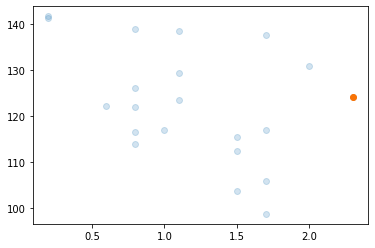

In [12]:
best_scores = pick_power_calculator(powers, schedule, best_pick)
best_point = [min(best_scores), sum(best_scores)]

f, ax = plt.subplots()
ax.scatter(*zip(*picks), alpha=0.2)

ax.scatter(*best_point, color="xkcd:orange")

(<Figure size 576x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1a0c9b5a00>)

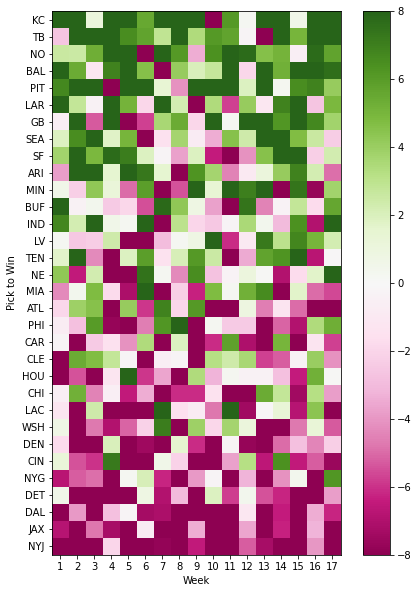

In [13]:
power_rank, matrix = pick_grid(powers, schedule, home_bump=3)

def plot_matrix(matrix, power_rank, cmap="PiYG"):
    f, ax = plt.subplots()
    f.set_size_inches((8, 10))
    imshow = ax.imshow(np.array(matrix).T, vmax=8, vmin=-8, cmap=cmap, origin="lower")
    ax.xaxis.set_ticks(list(range(17)))
    ax.xaxis.set_ticklabels(list(range(1, 18)))
    ax.xaxis.set_label_text("Week")
    ax.yaxis.set_ticks(list(range(32)))
    ax.yaxis.set_ticklabels(power_rank)
    ax.yaxis.set_label_text("Pick to Win")

    f.colorbar(imshow)
    
    return f, ax


plot_matrix(matrix, power_rank)

In [14]:
class PickModes(enum.Enum):
    BEST = "best"
    RANDOM = "random"
    RANDOM_BIASED = "random_biased"


class PickPermuter:
    def __init__(self, powers, schedule, home_bump=HOME_POWER_BUMP, past_picks=None):
        self.powers = powers
        
        self.schedule = schedule
        self.home_bump = home_bump
        
        self.update_pick_grid()
        
        if past_picks is None:
            self.past_picks = []
        else:
            self.past_picks = list(past_picks)
        
        self.pick = self.greedy()
                
    def update_pick_grid(self):
        self.grid_index, self.grid = pick_grid(self.powers, self.schedule, self.home_bump)

    def __repr__(self):
        score = self.pick_score
#         return "<{}\n {}\n {}\n min={}, avg={}, max={}>".format(
        return "<{}\n {}\n min={}, avg={}, max={}>".format(
            self.__class__.__name__,
            ", ".join(f"{p:>2s}" for p in self.pick),
#             ", ".join(f"{p:>5s}" for p in self.pick),
#             ", ".join(f"{s:>+4.1f}" for s in score),
            min(self.pick_score),
            statistics.mean(self.pick_score),
            max(self.pick_score),
        )

    def _make_pick(self, week, exclusions=None, mode=PickModes.BEST):
        if exclusions is None:
            exclusions = set()
            
        if mode is PickModes.BEST:
            picks = sorted(list(zip(week, self.grid_index)), reverse=True)
        elif mode is PickModes.RANDOM:
            picks = list(zip(week, self.grid_index))
            random.shuffle(picks)
        elif mode is PickModes.RANDOM_BIASED:
            picks = list(zip(week, self.grid_index))
            random.shuffle(picks)
        else:
            raise ValueError("unknown pick mode")
        for _score, pick in picks:
            if pick in exclusions:
                continue
            return pick    
        raise RuntimeError("no valid pick")
    
    def random(self):
        picks = self.past_picks[:] + [None] * (NUM_WEEKS - len(self.past_picks))
        n_weeks = list(range(len(self.past_picks), NUM_WEEKS))
        random.shuffle(n_weeks)
        for n_week in n_weeks:
            week = self.grid[n_week]
            pick = self._make_pick(week, exclusions=picks, mode=PickModes.RANDOM)
            picks[n_week] = pick
        return picks

    def greedy(self):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            pick = self._make_pick(week, exclusions=picks)
            picks.append(pick)
        assert len(picks) == len(self.grid) == 17
        return picks
    
    def reverse_greedy(self):
#         picks = self.past_picks[:]
        picks = []
        for week in reversed(self.grid[len(self.past_picks):]):
            pick = self._make_pick(week, exclusions=picks + self.past_picks)
            picks.append(pick)
        picks = self.past_picks + picks[::-1]
        assert len(picks) == len(self.grid) == NUM_WEEKS
        return picks
    
    def random_greedy(self):
        picks = self.past_picks[:] + [None] * (NUM_WEEKS - len(self.past_picks))
        n_weeks = list(range(len(self.past_picks), NUM_WEEKS))
        random.shuffle(n_weeks)
        for n_week in n_weeks:
            week = self.grid[n_week]
            pick = self._make_pick(week, exclusions=picks)
            picks[n_week] = pick
        return picks

    def limited_greedy(self, limit=10):
        picks = self.past_picks[:]
        for week in self.grid[len(picks):]:
            worst_picks = sorted(list(zip(week, self.grid_index)))
            pivot_index = bisect.bisect_left(worst_picks, (limit, "X"))
            order = (worst_picks[pivot_index:] + list(reversed(worst_picks[:pivot_index])))
            for _score, pick in order:
                if pick not in picks:
                    picks.append(pick)
                    break
            else:
                raise RuntimeError()
        assert len(picks) == len(self.grid) == 17
        return picks
    
    def greedy_anneal(self):
        picks = self.greedy()
    
    @property
    def pick_score(self):
        return pick_power_calculator(self.powers, self.schedule, self.pick, home_power=self.home_bump)
    
    def describe_pick(self):
        pick_power_calculator(
            self.powers, self.schedule, self.pick, 
            home_power=self.home_bump, 
            verbose=True, 
            ignore_weeks=len(self.past_picks),
        )
        
    @property
    def fitness(self):
#         return sum(score * k for score, k in zip(heapq.nsmallest(3, self.pick_score), [10, 3, 1]))
        return sum(score * 2**n for n, score in enumerate(sorted(self.pick_score, reverse=True)))

In [15]:
my_past_picks = [
    "KC",  # week 1
    "TEN", # week 2
    "IND", # week 3
    "LAR", # week 4
    "DAL", # week 5
    "MIA", # week 6
    "BUF", # week 7
    "TB",  # week 8
    "PIT", # week 9
    "GB",  # week 10
]

tuned_home_bump = 1.5

ppkwargs = {
    "powers": powers,
    "schedule": schedule,
    "home_bump": tuned_home_bump,
    "past_picks": my_past_picks
}

In [16]:
pp = PickPermuter(**ppkwargs)

pprev = PickPermuter(**ppkwargs)
pprev.pick = pprev.reverse_greedy()

pprand = PickPermuter(**ppkwargs)
pprand.pick = pprand.random_greedy()

pplg = PickPermuter(**ppkwargs)
pplg.pick = pplg.limited_greedy(limit=8)

In [17]:
pp.describe_pick()

week 11: diff +11.3 - picking MIN (+2.0+H) over DAL (-7.8  )
week 12: diff  +9.2 - picking NO  (+6.7  ) over DEN (-4.0+H)
week 13: diff +15.5 - picking BAL (+6.2+H) over DAL (-7.8  )
week 14: diff +14.5 - picking SEA (+4.0+H) over NYJ (-9.0  )
week 15: diff  +9.6 - picking SF  (+3.3  ) over DAL (-7.8+H)
week 16: diff  +5.5 - picking CLE (-2.0  ) over NYJ (-9.0+H)
week 17: diff +11.0 - picking NE  (+0.5+H) over NYJ (-9.0  )


In [18]:
pprev.describe_pick()

week 11: diff  +7.9 - picking LAC (-2.6+H) over NYJ (-9.0  )
week 12: diff  +9.2 - picking NO  (+6.7  ) over DEN (-4.0+H)
week 13: diff +12.1 - picking MIN (+2.0+H) over JAX (-8.6  )
week 14: diff +14.5 - picking SEA (+4.0+H) over NYJ (-9.0  )
week 15: diff  +9.6 - picking SF  (+3.3  ) over DAL (-7.8+H)
week 16: diff +12.3 - picking BAL (+6.2+H) over NYG (-4.6  )
week 17: diff +11.0 - picking NE  (+0.5+H) over NYJ (-9.0  )


In [19]:
pprand.describe_pick()

week 11: diff +11.3 - picking MIN (+2.0+H) over DAL (-7.8  )
week 12: diff  +5.1 - picking CLE (-2.0  ) over JAX (-8.6+H)
week 13: diff +15.5 - picking BAL (+6.2+H) over DAL (-7.8  )
week 14: diff +14.5 - picking SEA (+4.0+H) over NYJ (-9.0  )
week 15: diff  +9.6 - picking SF  (+3.3  ) over DAL (-7.8+H)
week 16: diff  +6.2 - picking NO  (+6.7+H) over MIN (+2.0  )
week 17: diff +11.0 - picking NE  (+0.5+H) over NYJ (-9.0  )


In [20]:
pplg.describe_pick()

week 11: diff  +9.1 - picking NO  (+6.7+H) over ATL (-0.9  )
week 12: diff  +5.5 - picking MIN (+2.0+H) over CAR (-2.0  )
week 13: diff  +8.7 - picking LV  (+1.2  ) over NYJ (-9.0+H)
week 14: diff  +8.5 - picking SF  (+3.3+H) over WSH (-3.7  )
week 15: diff +16.3 - picking BAL (+6.2+H) over JAX (-8.6  )
week 16: diff  +5.5 - picking CLE (-2.0  ) over NYJ (-9.0+H)
week 17: diff +11.0 - picking NE  (+0.5+H) over NYJ (-9.0  )


In [21]:
best_picks = []
best_fitness = -100
for n in range(100_000):
    pprand.pick = pprand.random_greedy()
    
    if pprand.fitness > best_fitness:
        print("new best fitness", int(pprand.fitness))
        best_picks = pprand.pick
        best_fitness = pprand.fitness
        
pprand.pick = best_picks
pprand.describe_pick()

new best fitness 359193
new best fitness 376401
new best fitness 455050
new best fitness 481242
week 11: diff +11.3 - picking MIN (+2.0+H) over DAL (-7.8  )
week 12: diff  +9.2 - picking NO  (+6.7  ) over DEN (-4.0+H)
week 13: diff  +8.7 - picking LV  (+1.2  ) over NYJ (-9.0+H)
week 14: diff +14.5 - picking SEA (+4.0+H) over NYJ (-9.0  )
week 15: diff  +9.6 - picking SF  (+3.3  ) over DAL (-7.8+H)
week 16: diff +12.3 - picking BAL (+6.2+H) over NYG (-4.6  )
week 17: diff +11.0 - picking NE  (+0.5+H) over NYJ (-9.0  )


In [22]:
best_picks = []
best_fitness = -100
for n in range(2_000_000):
    pprand.pick = pprand.random()
    
    try:
        if pprand.fitness > best_fitness:
            print("new best fitness", int(pprand.fitness))
            best_picks = pprand.pick
            best_fitness = pprand.fitness
    except ValueError:
        continue
        
pprand.pick = best_picks
pprand.describe_pick()

new best fitness 50122
new best fitness 66375
new best fitness 96350
new best fitness 101322
new best fitness 195070
new best fitness 196599
new best fitness 249445
new best fitness 261642
new best fitness 300641
week 11: diff  +9.1 - picking NO  (+6.7+H) over ATL (-0.9  )
week 12: diff  +5.1 - picking CLE (-2.0  ) over JAX (-8.6+H)
week 13: diff  +8.7 - picking LV  (+1.2  ) over NYJ (-9.0+H)
week 14: diff +14.5 - picking SEA (+4.0+H) over NYJ (-9.0  )
week 15: diff  +5.9 - picking MIN (+2.0+H) over CHI (-2.4  )
week 16: diff +12.3 - picking BAL (+6.2+H) over NYG (-4.6  )
week 17: diff +11.0 - picking NE  (+0.5+H) over NYJ (-9.0  )


## FiveThirtyEight Elo Data

* Links
    * https://projects.fivethirtyeight.com/2020-nfl-predictions/
    * https://github.com/fivethirtyeight/data/tree/master/nfl-elo
* Important Fields
    * `team1`	Abbreviation for home team
    * `team2`	Abbreviation for away team
    * `qbelo_prob1`	Home team's probability of winning according to quarterback-adjusted Elo
    * `qbelo_prob2`	Away team's probability of winning according to quarterback-adjusted Elo

In [57]:
nfl_538_api_url = "https://projects.fivethirtyeight.com/nfl-api/nfl_elo_latest.csv"
data = pd.read_csv(nfl_538_api_url)

In [58]:
data

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
0,2020-09-10,2020,0,NaN,KC,HOU,1664.847251,1527.930047,0.761756,0.238244,...,0.751961,0.248039,250.964371,163.113859,240.822204,192.365616,1663.567048,1485.102109,34.0,20.0
1,2020-09-13,2020,0,NaN,MIN,GB,1571.140027,1582.458606,0.576645,0.423355,...,0.531452,0.468548,272.758643,487.232745,169.663822,207.789554,1519.869687,1580.152199,34.0,43.0
2,2020-09-13,2020,0,NaN,ATL,SEA,1534.515566,1546.899069,0.575148,0.424852,...,0.489694,0.510306,322.269021,440.211288,193.861253,217.891363,1474.899700,1569.329677,25.0,38.0
3,2020-09-13,2020,0,NaN,BAL,CLE,1638.430875,1440.533332,0.819559,0.180441,...,0.743296,0.256704,363.493929,64.243357,272.200736,124.297844,1645.369446,1483.132850,38.0,6.0
4,2020-09-13,2020,0,NaN,CAR,OAK,1417.735566,1437.326108,0.564980,0.435020,...,0.504182,0.495818,221.339338,247.800792,161.791083,188.007296,1400.051159,1477.687771,30.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2021-01-24,2020,0,d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,2021-01-24,2020,0,d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,2021-01-31,2020,0,c,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,2021-01-31,2020,0,c,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
